In [7]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from IPython.display import display
import numpy as np
import os
import torch
from PIL import Image, ImageDraw

# SOMMAIRE

##### [Introduction](#dim)

##### I -  [Experiments setup](#Experiments)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;A - [Methods](#Methodes)    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;B - [Time to proceed experiment on 1 image](#Timeexp1im)  
##### II -  [Precision Analysis ](#precision)
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - [Methods comparaison](#Methodes)   
##### III -  [Time](#Time)
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; - [Methods comparaison](#Methodes)   
##### III -  [Complexity](#Complexity)

# <a id="Complexity"></a> Complexity

detailed line by line breakdown of execution time - optimizing code

In [37]:
from line_profiler import LineProfiler

## Many perturbations results

In [285]:
folder_path = "/Users/ncohmpli/Documents/Professionnel/Technical/Verification/Lirpa for IoU/manip/pipeline/lirpa_iou_pipeline/results/many_exp_true/"

In [286]:
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

In [287]:
dfs = []
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, converters={ 'IoU_vanilla':pd.eval,'IoU_extension':pd.eval,'IoU_extension_greedy':pd.eval})
    dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)

In [288]:
combined_df = combined_df.sort_values(by="image_id")

In [289]:
combined_df["IoU_vanilla_delta"] = combined_df.IoU_vanilla.apply(lambda x: x[1]-x[0])
combined_df["IoU_extension_delta"] = combined_df.IoU_extension.apply(lambda x: x[1]-x[0])

combined_df["Vanilla_upper"] = combined_df.IoU_vanilla.apply(lambda x: x[1])
combined_df["Vanilla_lower"] = combined_df.IoU_vanilla.apply(lambda x: x[0])
combined_df["Extension_upper"] = combined_df.IoU_extension.apply(lambda x: x[1])
combined_df["Extension_lower"] = combined_df.IoU_extension.apply(lambda x: x[0])

In [290]:
eps0 = combined_df[combined_df["eps"]==0]
bad_images_extension = np.unique(eps0[eps0["IoU_extension_delta"]>0.0001]["image_id"])
bad_images_vanilla = np.unique(eps0[eps0["IoU_vanilla_delta"]>0.0001]["image_id"])
def bad_images(im):
    if (im in bad_images_extension) or (im in bad_images_vanilla):
        return(True)
    return(False)
combined_df["bad_images"] = combined_df["image_id"].apply(lambda x: bad_images(x))

In [296]:
eps0[eps0["IoU_vanilla_delta"]>0.0001]["bounds_clip"]

5455     [[16.0865, 6.3216295, 42.86523, 33.177265], [1...
5456     [[16.0865, 6.3216295, 42.86523, 33.177265], [1...
5454     [[16.0865, 6.3216295, 42.86523, 33.177265], [1...
15150    [[22.874844, 50.156258, 49.39147, 77.22817], [...
15151    [[22.874844, 50.156258, 49.39147, 77.22817], [...
15152    [[22.874844, 50.156258, 49.39147, 77.22817], [...
22423    [[22.367748, 25.160849, 49.74377, 52.733757], ...
22422    [[22.367748, 25.160849, 49.74377, 52.733757], ...
22424    [[22.367748, 25.160849, 49.74377, 52.733757], ...
18182    [[1.4151869, 1.0546236, 28.62641, 28.404108], ...
18181    [[1.4151869, 1.0546236, 28.62641, 28.404108], ...
18180    [[1.4151869, 1.0546236, 28.62641, 28.404108], ...
25454    [[17.28731, 3.8842824, 44.62356, 31.605045], [...
25453    [[17.28731, 3.8842824, 44.62356, 31.605045], [...
25452    [[17.28731, 3.8842824, 44.62356, 31.605045], [...
15758    [[15.44386, 27.050077, 43.477005, 54.902195], ...
15757    [[15.44386, 27.050077, 43.477005, 54.902195], .

In [292]:
eps0[combined_df["bad_images"] == True][[

Unnamed: 0  image_id  gt_logit       eps  fake_iou perturbation  \
5756          302         4         0  0.005600      True     contrast   
5604          150         4         0  0.002800      True   whitenoise   
5606          152         4         0  0.002800      True     contrast   
5549           95         4         0  0.001736      True     contrast   
5550           96         4         0  0.001792      True   whitenoise   
...           ...       ...       ...       ...       ...          ...   
18990         204        96         0  0.003808      True   whitenoise   
18991         205        96         0  0.003808      True   brightness   
18992         206        96         0  0.003808      True     contrast   
18985         199        96         0  0.003696      True   brightness   
19011         225        96         0  0.004200      True   whitenoise   

                                             bounds_clip  \
5756                    [[0, 0, 0, 0], [90, 90, 90, 90]]   
5604   [[0, 0, 19.03007, 14.99313], [72.97056, 56.691...   
5606   [[0, 0, 20.324951, 16.222076], [72.71924, 56.3...   
5549   [[4.844836, 0, 30.25047, 24.654263], [43.58332...   
5550   [[3.9261563, 0, 28.884768, 23.520088], [45.229...   
...                                                  ...   
18990  [[0, 15.255926, 8.813261, 37.992027], [90, 90,...   
18991  [[0, 17.092392, 10.821557, 40.70679], [90, 90,...   
18992  [[0, 17.092392, 10.821557, 40.70679], [90, 90,...   
18985  [[0, 18.840082, 12.491202, 42.722527], [90, 90...   
19011  [[0, 8.397121, 2.7969027, 30.505964], [90, 90,...   

       elapsed_time_perturbation  elapsed_time_eps_computed_ious IoU_vanilla  \
5756                    0.276242                        0.004393      [0, 1]   
5604                    0.303696                        0.001676      [0, 1]   
5606                    0.303696                        0.004356      [0, 1]   
5549                    0.319936                        0.004699      [0, 1]   
5550                    0.305845                        0.001681      [0, 1]   
...                          ...                             ...         ...   
18990                   0.285671                        0.001680      [0, 1]   
18991                   0.285671                        0.003032      [0, 1]   
18992                   0.285671                        0.004382      [0, 1]   
18985                   0.285893                        0.003051      [0, 1]   
19011                   0.264083                        0.001659      [0, 1]   

       tmps_vanilla IoU_extension  tmps_extension  IoU_vanilla_delta  \
5756            0.0        [0, 1]             0.0                1.0   
5604            0.0        [0, 1]             0.0                1.0   
5606            0.0        [0, 1]             0.0                1.0   
5549            0.0        [0, 1]             0.0                1.0   
5550            0.0        [0, 1]             0.0                1.0   
...             ...           ...             ...                ...   
18990           0.0        [0, 1]             0.0                1.0   
18991           0.0        [0, 1]             0.0                1.0   
18992           0.0        [0, 1]             0.0                1.0   
18985           0.0        [0, 1]             0.0                1.0   
19011           0.0        [0, 1]             0.0                1.0   

       IoU_extension_delta  Vanilla_upper  Vanilla_lower  Extension_upper  \
5756                   1.0            1.0            0.0              1.0   
5604                   1.0            1.0            0.0              1.0   
5606                   1.0            1.0            0.0              1.0   
5549                   1.0            1.0            0.0              1.0   
5550                   1.0            1.0            0.0              1.0   
...                    ...            ...            ...              ...   
18990                  1.0      

In [180]:

combined_df = combined_df[combined_df["bad_images"] == False]

In [181]:
combined_df = combined_df[combined_df["eps"] <= 0.0009]

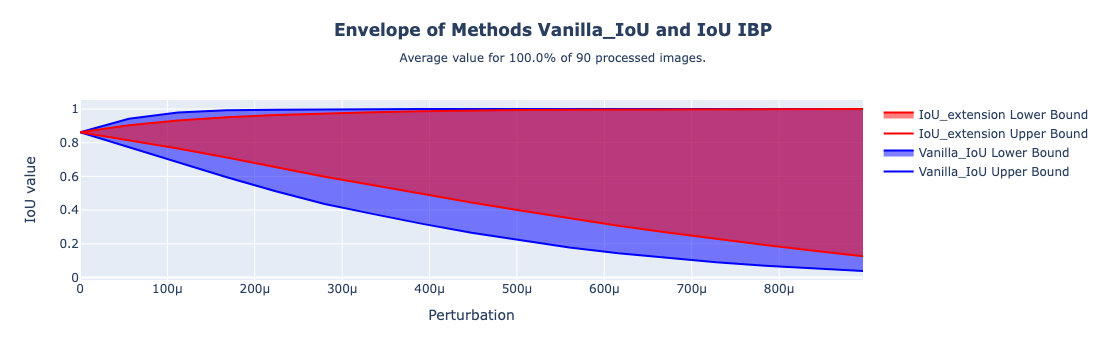

In [182]:
def envelop_graph(df_grouped, title='Envelope of Methods Vanilla_IoU and IoU IBP', subtitle=None, subsubtitle=""):
    """df should have the columns
    "Eps" "Vanilla_upper", "Vanilla_lower", "Extension_upper", "Extension_lower"
    """

    trace_A = go.Scatter(
        x=df_grouped["eps"],
        y=df_grouped["Vanilla_upper"],
        fill=None,
        mode='lines',
        line=dict(color='blue'),
        name='Vanilla_IoU Upper Bound'
    )
    trace_A_lower = go.Scatter(
        x=df_grouped["eps"],
        y=df_grouped["Vanilla_lower"],
        fill='tonexty',  # Espace remplissage ! 
        mode='lines',
        line=dict(color='blue'),
        name='Vanilla_IoU Lower Bound'
    )
    trace_B = go.Scatter(
        x=df_grouped["eps"],
        y=df_grouped["Extension_upper"],
        fill=None,
        mode='lines',
        line=dict(color='red'),
        name='IoU_extension Upper Bound'
    )
    trace_B_lower = go.Scatter(
        x=df_grouped["eps"],
        y=df_grouped["Extension_lower"],
        fill='tonexty',  # Espace remplissage ! 
        mode='lines',
        line=dict(color='red'),
        name='IoU_extension Lower Bound'
    )
    
    layout = go.Layout(
        title=title,
        xaxis=dict(title='Perturbation'),
        yaxis=dict(title='IoU value')
    )
    
    fig = go.Figure(layout=layout)
    fig.add_trace(trace_A)
    fig.add_trace(trace_A_lower)
    fig.add_trace(trace_B)
    fig.add_trace(trace_B_lower)

    if subtitle != None:
        fig.update_layout(
            title={'text': f'<b>{title}</b><br><sub>{subtitle}</sub><br><sub><i>{subsubtitle}</i></sub>',
           'y':0.9,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'}
            )


    return(fig)

df_grouped = combined_df.groupby("eps")[["Vanilla_upper", "Vanilla_lower", "Extension_upper", "Extension_lower"]].agg("mean")
df_grouped = df_grouped.reset_index()

def percentage_value(df_plotted, df=df):
    """Percentage images processed on this plot
    """
    plotted = len(np.unique(list(df_plotted["image_id"])))
    globaldf = len(np.unique(list(df["image_id"])))
    return((plotted/globaldf)*100)
nb_im_proc = combined_df.groupby("image_id")[["eps"]].agg("count").shape[0]
envelop_graph(df_grouped, title=f'Envelope of Methods Vanilla_IoU and IoU IBP', subtitle=f"Average value for {percentage_value(df)}% of {nb_im_proc} processed images.")

In [302]:
dico_pert={}
for perturbation_i in np.unique(combined_df["perturbation"]):
    dico_pert[perturbation_i] = combined_df[combined_df["perturbation"] == perturbation_i]

In [305]:
dico_pert["brightness"].describe()

Unnamed: 0      image_id  gt_logit           eps  \
count  10100.000000  10100.000000   10100.0  10100.000000   
mean     151.000000     49.500000       0.0      0.002800   
std       87.468609     28.867499       0.0      0.001633   
min        1.000000      0.000000       0.0      0.000000   
25%       76.000000     24.750000       0.0      0.001400   
50%      151.000000     49.500000       0.0      0.002800   
75%      226.000000     74.250000       0.0      0.004200   
max      301.000000     99.000000       0.0      0.005600   

       elapsed_time_perturbation  elapsed_time_eps_computed_ious  \
count               10100.000000                    10100.000000   
mean                    0.601549                        0.006374   
std                    31.629583                        0.006389   
min                     0.162203                        0.002505   
25%                     0.272573                        0.003011   
50%                     0.282311                        0.003065   
75%                     0.296746                        0.003224   
max                  3179.019837                        0.032567   

       tmps_vanilla  tmps_extension  IoU_vanilla_delta  IoU_extension_delta  \
count  10100.000000    10100.000000       10100.000000         1.010000e+04   
mean       0.000013        0.001572           0.940454         9.140851e-01   
std        0.000025        0.003014           0.174738         2.145818e-01   
min        0.000000        0.000000           0.000000        -2.754517e-08   
25%        0.000000        0.000000           1.000000         1.000000e+00   
50%        0.000000        0.000000           1.000000         1.000000e+00   
75%        0.000000        0.000000           1.000000         1.000000e+00   
max        0.000120        0.012397           1.000000         1.000000e+00   

       Vanilla_upper  Vanilla_lower  Extension_upper  Extension_lower  
count   10100.000000   10100.000000     10100.000000     10100.000000  
mean        0.997928       0.057474         0.995610         0.081525  
std         0.018315       0.165311         0.024739         0.200321  
min         0.623142       0.000000         0.623142         0.000000  
25%         1.000000       0.000000         1.000000         0.000000  
50%         1.000000       0.000000         1.000000         0.000000  
75%         1.000000       0.000000         1.000000         0.000000  
max         1.000000       0.985932         1.000000         0.985932

In [307]:
dico_pert["whitenoise"].describe()

Unnamed: 0      image_id  gt_logit           eps  \
count  10100.000000  10100.000000   10100.0  10100.000000   
mean     150.000000     49.500000       0.0      0.002800   
std       87.468609     28.867499       0.0      0.001633   
min        0.000000      0.000000       0.0      0.000000   
25%       75.000000     24.750000       0.0      0.001400   
50%      150.000000     49.500000       0.0      0.002800   
75%      225.000000     74.250000       0.0      0.004200   
max      300.000000     99.000000       0.0      0.005600   

       elapsed_time_perturbation  elapsed_time_eps_computed_ious  \
count               10100.000000                    10100.000000   
mean                    0.601549                        0.003358   
std                    31.629583                        0.003248   
min                     0.162203                        0.001395   
25%                     0.272573                        0.001668   
50%                     0.282311                        0.001699   
75%                     0.296746                        0.001776   
max                  3179.019837                        0.017357   

       tmps_vanilla  tmps_extension  IoU_vanilla_delta  IoU_extension_delta  \
count  10100.000000    10100.000000       10100.000000         1.010000e+04   
mean       0.000014        0.001582           0.941964         9.155773e-01   
std        0.000027        0.003086           0.172656         2.129921e-01   
min        0.000000        0.000000           0.000000        -2.754517e-08   
25%        0.000000        0.000000           1.000000         1.000000e+00   
50%        0.000000        0.000000           1.000000         1.000000e+00   
75%        0.000000        0.000000           1.000000         1.000000e+00   
max        0.000208        0.014079           1.000000         1.000000e+00   

       Vanilla_upper  Vanilla_lower  Extension_upper  Extension_lower  
count   10100.000000   10100.000000     10100.000000     10100.000000  
mean        0.997995       0.056032         0.995871         0.080294  
std         0.018060       0.163370         0.024074         0.199302  
min         0.623142       0.000000         0.623142         0.000000  
25%         1.000000       0.000000         1.000000         0.000000  
50%         1.000000       0.000000         1.000000         0.000000  
75%         1.000000       0.000000         1.000000         0.000000  
max         1.000000       0.985932         1.000000         0.985932

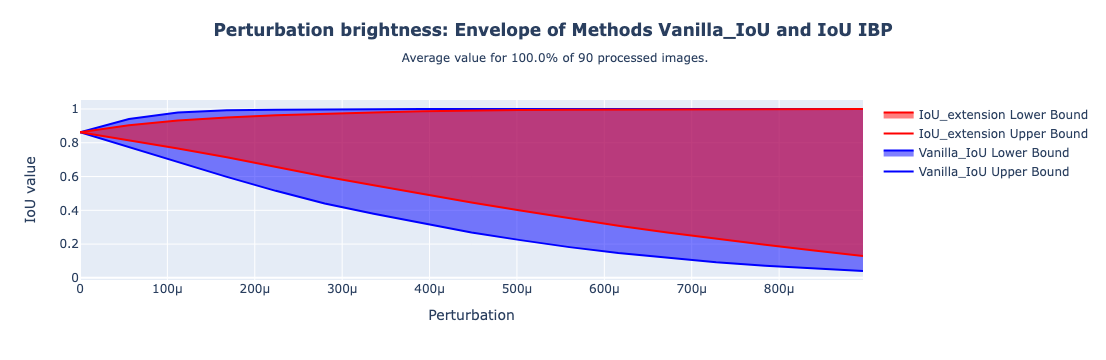

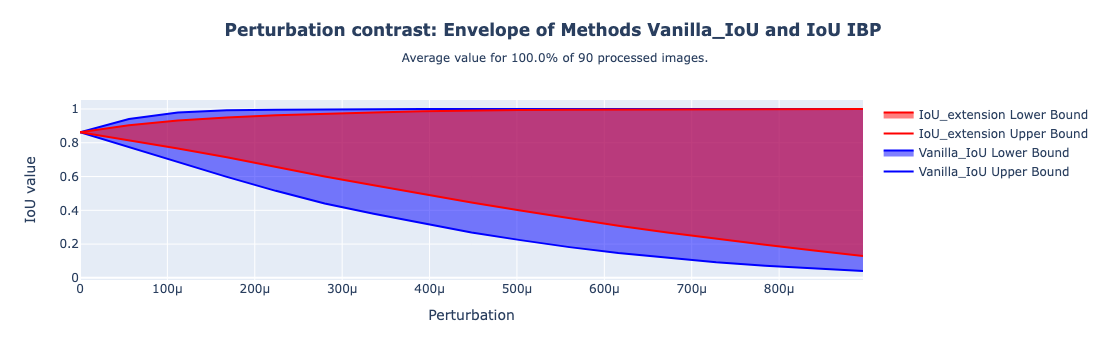

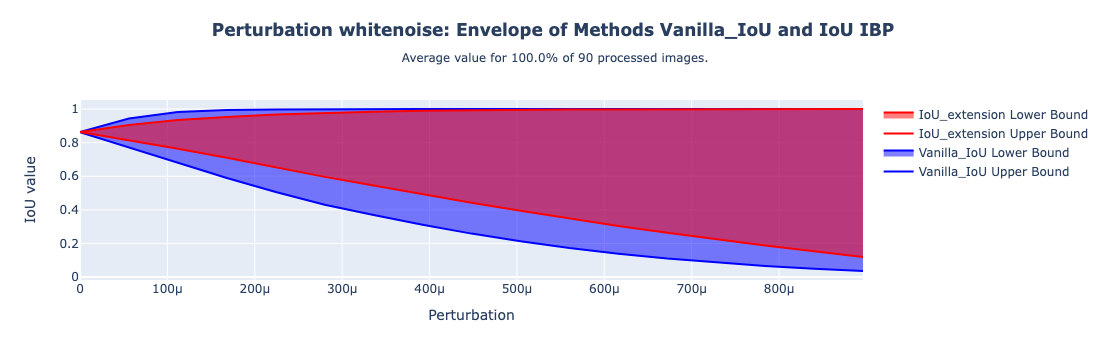

In [204]:
for perturbation_i in np.unique(combined_df["perturbation"]):
    df_grouped = combined_df[combined_df["perturbation"] == perturbation_i].groupby("eps")[["Vanilla_upper", "Vanilla_lower", "Extension_upper", "Extension_lower"]].agg("mean")
    df_grouped = df_grouped.reset_index()
    envelop_graph(df_grouped, title=f'Perturbation {perturbation_i}: Envelope of Methods Vanilla_IoU and IoU IBP', subtitle=f" Average value for {percentage_value(df)}% of {nb_im_proc} processed images.").show()

In [205]:
def display_im(idx):
    im4 = torch.tensor([images.iloc[idx][1:]])
    im4 = im4.view((-1, 1, 90, 90))
    im4 = im4.squeeze()
    im4 = im4.mul(255).byte()
    pil_image = Image.fromarray(im4.cpu().numpy(), mode="L")
    draw = ImageDraw.Draw(pil_image)
    pil_image.show()

# <a id="Time"></a> Time analysis

In [195]:
'elapsed_time_eps_computed_ious'
describe_tmps


tmps_vanilla  tmps_extension
count   1530.000000     1530.000000
mean       0.000059        0.007322
std        0.000006        0.000337
min        0.000046        0.006046
25%        0.000055        0.007115
50%        0.000057        0.007284
75%        0.000064        0.007460
max        0.000101        0.012397

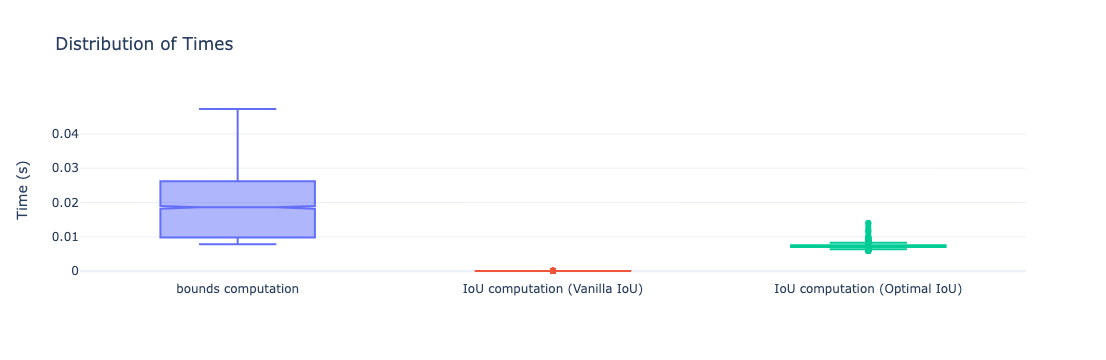

In [227]:
def create_box_plot(df, columns):
    df_long = df.melt(value_vars=columns, var_name='Time', value_name='Value')
    fig = px.box(df_long, x='Time', y='Value', color='Time', 
                 notched=True,  
                 title='Distribution of Times')

    fig.update_layout(
        yaxis_title='Time (s)',  
        xaxis_title='',
        template='plotly_white',  
        showlegend=False  
    )
    
    fig.show()


create_box_plot(combined_df.rename(columns={
    'elapsed_time_eps_computed_ious':'bounds computation',
    "tmps_vanilla":'IoU computation (Vanilla IoU)',
    "tmps_extension":'IoU computation (Optimal IoU)'}), ['bounds computation', 'IoU computation (Vanilla IoU)',	'IoU computation (Optimal IoU)'])

In [199]:
combined_df.columns

Index(['Unnamed: 0', 'image_id', 'gt_logit', 'eps', 'fake_iou', 'perturbation',
       'bounds_clip', 'elapsed_time_perturbation',
       'elapsed_time_eps_computed_ious', 'IoU_vanilla', 'tmps_vanilla',
       'IoU_extension', 'tmps_extension', 'IoU_vanilla_delta',
       'IoU_extension_delta', 'Vanilla_upper', 'Vanilla_lower',
       'Extension_upper', 'Extension_lower', 'bad_images'],
      dtype='object')

# Best or worst images 

In [206]:
df_groupybimage = combined_df.groupby("image_id")[["IoU_vanilla_delta",	"IoU_extension_delta"]].agg("mean")
df_groupybimage["enveloppe_diff"] = df_groupybimage["IoU_vanilla_delta"]-df_groupybimage["IoU_extension_delta"]

In [207]:
df_groupybimage

IoU_vanilla_delta  IoU_extension_delta  enveloppe_diff
image_id                                                        
0                  0.621432             0.484467        0.136964
1                  0.636969             0.510091        0.126879
2                  0.604292             0.427815        0.176478
3                  0.698698             0.522650        0.176048
5                  0.597241             0.405055        0.192187
...                     ...                  ...             ...
94                 0.694717             0.534120        0.160597
95                 0.666378             0.476646        0.189732
97                 0.671837             0.494304        0.177534
98                 0.652425             0.511254        0.141171
99                 0.679327             0.531822        0.147505

[90 rows x 3 columns]

In [210]:
list_perturb=list(combined_df.groupby("image_id")[["IoU_vanilla_delta"]].agg("count")[combined_df.groupby("image_id")[["IoU_vanilla_delta"]].agg("count")<8].dropna().index)
df_groupybimage = df_groupybimage.drop(index=list_perturb)

In [283]:
df_groupybimage.sort_values(by="enveloppe_diff").head(2)

IoU_vanilla_delta  IoU_extension_delta  enveloppe_diff
image_id                                                        
73                 0.588603             0.488321        0.100282
71                 0.640423             0.540087        0.100336

In [284]:
display_im(73)

/var/folders/85/rkcmsdf568q3lwnpbg8swry40000gn/T/ipykernel_14532/3163306392.py:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



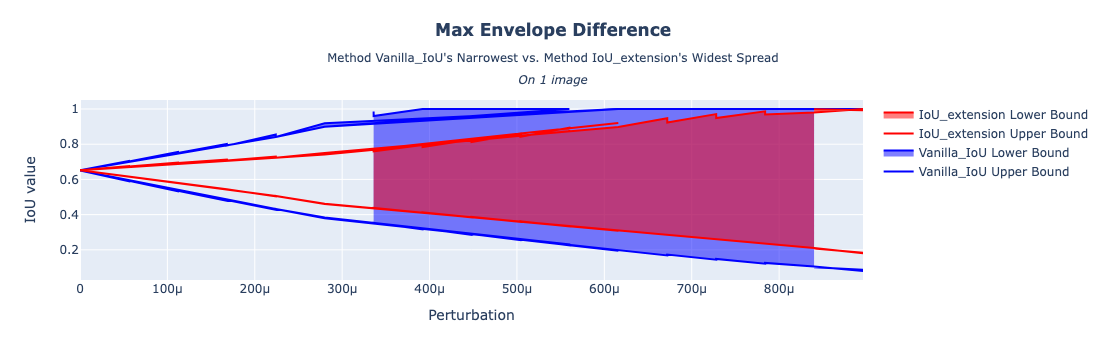

In [223]:
envelop_graph(combined_df[combined_df["image_id"] ==2 ], title="Max Envelope Difference", 
              subtitle="Method Vanilla_IoU's Narrowest vs. Method IoU_extension's Widest Spread",
             subsubtitle="On 1 image")

In [219]:
combined_df[combined_df["image_id"] == 80 ]

Unnamed: 0  image_id  gt_logit       eps  fake_iou perturbation  \
23331           0        80         0  0.000000     False   whitenoise   
23381          50        80         0  0.000896     False     contrast   
23380          49        80         0  0.000896     False   brightness   
23379          48        80         0  0.000896     False   whitenoise   
23378          47        80         0  0.000840     False     contrast   
23377          46        80         0  0.000840     False   brightness   
23376          45        80         0  0.000840     False   whitenoise   
23375          44        80         0  0.000784     False     contrast   
23374          43        80         0  0.000784     False   brightness   
23373          42        80         0  0.000784     False   whitenoise   
23372          41        80         0  0.000728     False     contrast   
23371          40        80         0  0.000728     False   brightness   
23370          39        80         0  0.000728     False   whitenoise   
23369          38        80         0  0.000672     False     contrast   
23368          37        80         0  0.000672     False   brightness   
23366          35        80         0  0.000616     False     contrast   
23346          15        80         0  0.000280     False   whitenoise   
23345          14        80         0  0.000224     False     contrast   
23344          13        80         0  0.000224     False   brightness   
23343          12        80         0  0.000224     False   whitenoise   
23342          11        80         0  0.000168     False     contrast   
23341          10        80         0  0.000168     False   brightness   
23340           9        80         0  0.000168     False   whitenoise   
23339           8        80         0  0.000112     False     contrast   
23338           7        80         0  0.000112     False   brightness   
23337           6        80         0  0.000112     False   whitenoise   
23336           5        80         0  0.000056     False     contrast   
23335           4        80         0  0.000056     False   brightness   
23334           3        80         0  0.000056     False   whitenoise   
23333           2        80         0  0.000000     False     contrast   
23347          16        80         0  0.000280     False   brightness   
23367          36        80         0  0.000672     False   whitenoise   
23348          17        80         0  0.000280     False     contrast   
23350          19        80         0  0.000336     False   brightness   
23365          34        80         0  0.000616     False   brightness   
23364          33        80         0  0.000616     False   whitenoise   
23363          32        80         0  0.000560     False     contrast   
23362          31        80         0  0.000560     False   brightness   
23361          30        80         0  0.000560     False   whitenoise   
23360          29        80         0  0.000504     False     contrast   
23359          28        80         0  0.000504     False   brightness   
23358          27        80         0  0.000504     False   whitenoise   
23357          26        80         0  0.000448     False     contrast   
23356          25        80         0  0.000448     False   brightness   
23355          24        80         0  0.000448     False   whitenoise   
23354          23        80         0  0.000392     False     contrast   
23353          22        80         0  0.000392     False   brightness   
23352          21        80         0  0.000392     False   whitenoise   
23351          20        80         0  0.000336     False     contrast   
23349          18        80         0  0.000336     False   whitenoise   
23332           1        80         0  0.000000     False   brightness   

                                             bounds_clip  \
23331  [[67.22165, 40.22486, 90, 71.0222], [67.22165,...   
23381  [[61.680893, 35.676346, 90, 65.

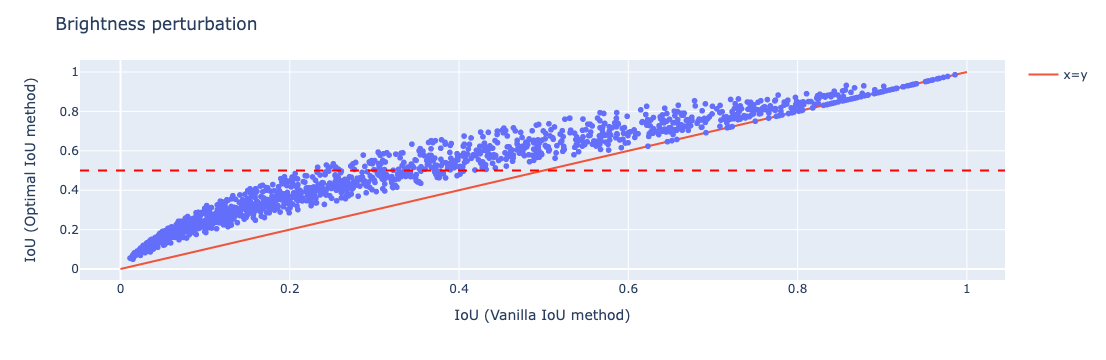

In [258]:

kk = combined_df[combined_df["perturbation"]=="brightness"].rename(columns={
    "Vanilla_lower":"IoU (Vanilla IoU method)",
    "Extension_lower":"IoU (Optimal IoU method)"})
fig = px.scatter(kk, x="IoU (Vanilla IoU method)", y="IoU (Optimal IoU method)")
fig.add_hline(y=0.5, line_dash="dash", line_color="red")
#fig.add_vline(x=0.5, line_dash="dash", line_color="orange")
fig.add_trace(go.Scatter(x=[0,1], y=[0,1], mode='lines', name='x=y'))
fig.update_layout(title='Brightness perturbation' )
fig.show()




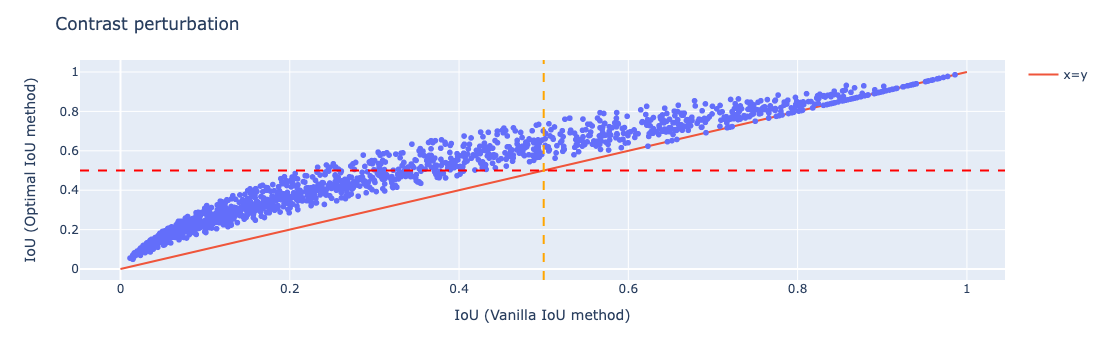

In [259]:
kk = combined_df[combined_df["perturbation"]=="contrast"].rename(columns={
    "Vanilla_lower":"IoU (Vanilla IoU method)",
    "Extension_lower":"IoU (Optimal IoU method)"})
fig = px.scatter(kk, x="IoU (Vanilla IoU method)", y="IoU (Optimal IoU method)")
fig.add_hline(y=0.5, line_dash="dash", line_color="red")
fig.add_vline(x=0.5, line_dash="dash", line_color="orange")
fig.add_trace(go.Scatter(x=[0,1], y=[0,1], mode='lines', name='x=y'))
fig.update_layout(title='Contrast perturbation' )
fig.show()

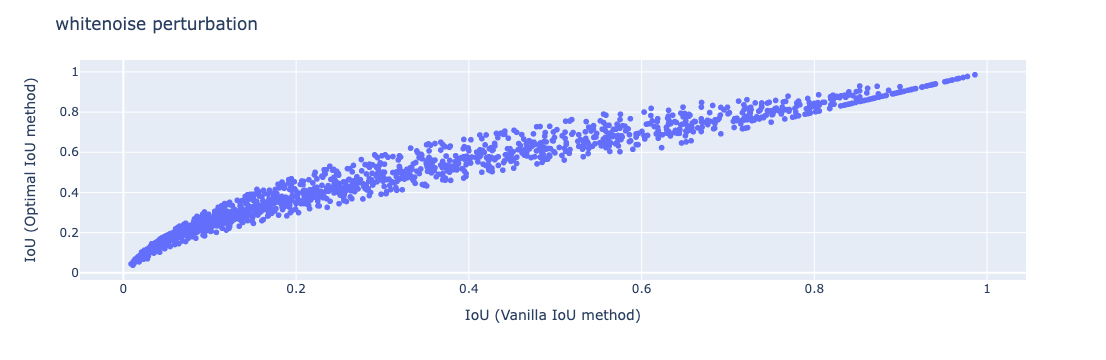

In [252]:
kk = combined_df[combined_df["perturbation"]=="whitenoise"].rename(columns={
    "Vanilla_lower":"IoU (Vanilla IoU method)",
    "Extension_lower":"IoU (Optimal IoU method)"})
fig = px.scatter(kk, x="IoU (Vanilla IoU method)", y="IoU (Optimal IoU method)")
fig.update_layout(title='whitenoise perturbation' )
fig.show()

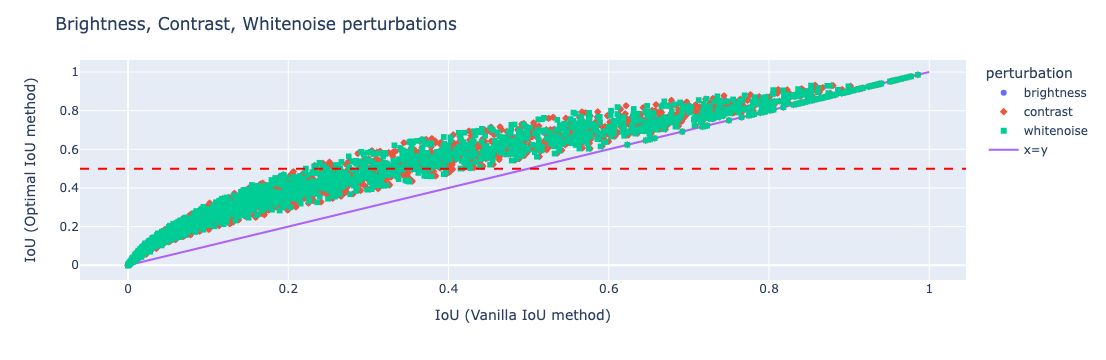

In [301]:
kk = combined_df.rename(columns={
    "Vanilla_lower":"IoU (Vanilla IoU method)",
    "Extension_lower":"IoU (Optimal IoU method)"})
fig = px.scatter(kk, x="IoU (Vanilla IoU method)", y="IoU (Optimal IoU method)", symbol="perturbation", color="perturbation")
fig.add_hline(y=0.5, line_dash="dash", line_color="red")
#fig.add_vline(x=0.5, line_dash="dash", line_color="orange")
fig.add_trace(go.Scatter(x=[0,1], y=[0,1], mode='lines', name='x=y'))
fig.update_layout(title='Brightness, Contrast, Whitenoise perturbations' )
fig.show()


In [244]:
kk[['IoU (Vanilla IoU method)']]

IoU (Vanilla IoU method)
12727                  0.940194
12746                  0.425023
12747                  0.351605
12748                  0.362700
12749                  0.362700
...                         ...
22167                  0.021625
22168                  0.026023
22169                  0.026023
22121                  0.817978
22120                  0.817978

[4590 rows x 1 columns]

Unnamed: 0  image_id  gt_logit       eps  fake_iou perturbation  \
12727           1         0         0  0.000000     False   brightness   
12748          22         0         0  0.000392     False   brightness   
12751          25         0         0  0.000448     False   brightness   
12754          28         0         0  0.000504     False   brightness   
12757          31         0         0  0.000560     False   brightness   
...           ...       ...       ...       ...       ...          ...   
22159          40        99         0  0.000728     False   brightness   
22162          43        99         0  0.000784     False   brightness   
22165          46        99         0  0.000840     False   brightness   
22168          49        99         0  0.000896     False   brightness   
22120           1        99         0  0.000000     False   brightness   

                                             bounds_clip  \
12727  [[29.806683, 14.438718, 57.42273, 42.527035], ...   
12748  [[28.600836, 13.718106, 55.828335, 41.49885], ...   
12751  [[28.3219, 13.568571, 55.4656, 41.26471], [34....   
12754  [[28.039062, 13.409054, 55.105293, 41.036644],...   
12757  [[27.72555, 13.229025, 54.70803, 40.789585], [...   
...                                                  ...   
22159  [[45.447422, 22.059963, 73.11027, 49.93985], [...   
22162  [[45.061718, 21.74013, 72.6239, 49.516357], [6...   
22165  [[44.67388, 21.417389, 72.13287, 49.087524], [...   
22168  [[44.285725, 21.103542, 71.656166, 48.790276],...   
22120  [[49.236916, 25.056616, 77.97139, 53.980453], ...   

       elapsed_time_perturbation  elapsed_time_eps_computed_ious  \
12727                   0.384682                        0.020086   
12748                   0.310956                        0.019296   
12751                   0.300118                        0.018852   
12754                   0.279219                        0.018680   
12757                   0.318747                        0.019127   
...                          ...                             ...   
22159                   0.295822                        0.017618   
22162                   0.300783                        0.019305   
22165                   0.290060                        0.017769   
22168                   0.295270                        0.018465   
22120                   0.305708                        0.019263   

                                    IoU_vanilla  tmps_vanilla  \
12727  [0.9401939728397936, 0.9401939728397936]      0.000056   
12748                   [0.3626996778613171, 1]      0.000056   
12751                  [0.30499377022539664, 1]      0.000056   
12754                  [0.25565332191575657, 1]      0.000056   
12757                  [0.21044435530580005, 1]      0.000057   
...                                         ...           ...   
22159                  [0.07054763881474078, 1]      0.000058   
22162                 [0.052681912704165806, 1]      0.000067   
22165                  [0.03787789946112797, 1]      0.000059   
22168                 [0.026022758074953477, 1]      0.000065   
22120  [0.8179779870776601, 0.8179779870776601]      0.000058   

                          IoU_extension  tmps_extension  IoU_vanilla_delta  \
12727  [0.9401939511299133, 0.94019395]        0.007692           0.000000   
12748         [0.5301610827445984, 1.0]        0.007562           0.637300   
12751        [0.47653722763061523, 1.0]        0.007390           0.695006   
12754         [0.4269661605358124, 1.0]        0.007290           0.744347   
12757         [0.3782447874546051, 1.0]        0.007481           0.789556   
...                                 ...             ...                ...   
22159          [0.217938631772995, 1.0]        0.006950           0.929452   
22162         [0.1793755143880844, 1.0]        0.007467           0.947318   
22165        [0.14151445031166077, 1.0]        0.006514           0.962122   
22168        [0.101

In [241]:
combined_df

Unnamed: 0  image_id  gt_logit       eps  fake_iou perturbation  \
12727           1         0         0  0.000000     False   brightness   
12746          20         0         0  0.000336     False     contrast   
12747          21         0         0  0.000392     False   whitenoise   
12748          22         0         0  0.000392     False   brightness   
12749          23         0         0  0.000392     False     contrast   
...           ...       ...       ...       ...       ...          ...   
22167          48        99         0  0.000896     False   whitenoise   
22168          49        99         0  0.000896     False   brightness   
22169          50        99         0  0.000896     False     contrast   
22121           2        99         0  0.000000     False     contrast   
22120           1        99         0  0.000000     False   brightness   

                                             bounds_clip  \
12727  [[29.806683, 14.438718, 57.42273, 42.527035], ...   
12746  [[28.837557, 13.85047, 56.13203, 41.693127], [...   
12747  [[28.473392, 13.648253, 55.61319, 41.343662], ...   
12748  [[28.600836, 13.718106, 55.828335, 41.49885], ...   
12749  [[28.600836, 13.718106, 55.828335, 41.49885], ...   
...                                                  ...   
22167  [[43.849506, 20.848616, 71.02205, 48.34973], [...   
22168  [[44.285725, 21.103542, 71.656166, 48.790276],...   
22169  [[44.285725, 21.103542, 71.656166, 48.790276],...   
22121  [[49.236916, 25.056616, 77.97139, 53.980453], ...   
22120  [[49.236916, 25.056616, 77.97139, 53.980453], ...   

       elapsed_time_perturbation  elapsed_time_eps_computed_ious  \
12727                   0.384682                        0.020086   
12746                   0.289327                        0.029495   
12747                   0.310956                        0.009948   
12748                   0.310956                        0.019296   
12749                   0.310956                        0.028318   
...                          ...                             ...   
22167                   0.295270                        0.009640   
22168                   0.295270                        0.018465   
22169                   0.295270                        0.026166   
22121                   0.305708                        0.028473   
22120                   0.305708                        0.019263   

                                    IoU_vanilla  tmps_vanilla  \
12727  [0.9401939728397936, 0.9401939728397936]      0.000056   
12746                  [0.42502288450864567, 1]      0.000060   
12747                    [0.351605456196351, 1]      0.000061   
12748                   [0.3626996778613171, 1]      0.000056   
12749                   [0.3626996778613171, 1]      0.000056   
...                                         ...           ...   
22167                  [0.02162539609080505, 1]      0.000071   
22168                 [0.026022758074953477, 1]      0.000065   
22169                 [0.026022758074953477, 1]      0.000052   
22121  [0.8179779870776601, 0.8179779870776601]      0.000059   
22120  [0.8179779870776601, 0.8179779870776601]      0.000058   

                          IoU_extension  tmps_extension  IoU_vanilla_delta  \
12727  [0.9401939511299133, 0.94019395]        0.007692           0.000000   
12746         [0.5856223106384277, 1.0]        0.007546           0.574977   
12747         [0.5283302068710327, 1.0]        0.007835           0.648395   
12748         [0.5301610827445984, 1.0]        0.007562           0.637300   
12749         [0.5301610827445984, 1.0]        0.007309           0.637300   
...                                 ...             ...                ...   
22167        [0.08585081994533539, 1.0]        0.007598           0.978375   
22168        [0.10161251574754715, 1.0]        0.007106           0.973977   
22169        [0.10161251574754715, 1.0]        0.006206           0.973977   
22121  [0.817977964

In [273]:
avg_precision = combined_df.groupby(["eps", "perturbation"])[["IoU_vanilla_delta",	"IoU_extension_delta"]].agg("mean")
avg_precision.reset_index().head(5)

eps perturbation  IoU_vanilla_delta  IoU_extension_delta
0  0.000000   brightness           0.000000        -1.696303e-10
1  0.000000     contrast           0.000000        -1.696303e-10
2  0.000000   whitenoise           0.000000        -1.696303e-10
3  0.000056   brightness           0.165869         8.760233e-02
4  0.000056     contrast           0.165869         8.760233e-02

In [276]:
df_melted

eps               method  IoU delta value  IoU delta value * 100
0    0.000000    IoU_vanilla_delta         0.000000               0.000000
1    0.000000    IoU_vanilla_delta         0.000000               0.000000
2    0.000000    IoU_vanilla_delta         0.000000               0.000000
3    0.000056    IoU_vanilla_delta         0.165869              16.586898
4    0.000056    IoU_vanilla_delta         0.165869              16.586898
..        ...                  ...              ...                    ...
97   0.000840  IoU_extension_delta         0.836955              83.695511
98   0.000840  IoU_extension_delta         0.846776              84.677579
99   0.000896  IoU_extension_delta         0.869693              86.969279
100  0.000896  IoU_extension_delta         0.869693              86.969279
101  0.000896  IoU_extension_delta         0.880491              88.049137

[102 rows x 4 columns]

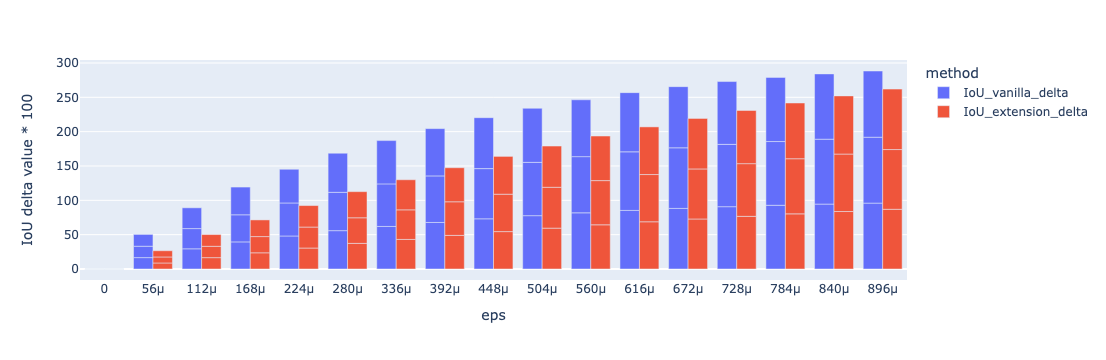

In [275]:
avg_precision = combined_df.groupby(["eps", "perturbation"])[["IoU_vanilla_delta",	"IoU_extension_delta"]].agg("mean")
avg_precision.reset_index().head(5)
avg_precision = combined_df.groupby(["eps", "perturbation"])[["IoU_vanilla_delta",	"IoU_extension_delta"]].agg("mean")
df_melted = avg_precision.reset_index().melt(id_vars='eps', value_vars=["IoU_vanilla_delta",	"IoU_extension_delta"], 
                                             var_name='method', 
                                             value_name='IoU delta value')
df_melted["IoU delta value * 100"] = df_melted["IoU delta value"].apply(lambda x: x*100)
px.bar(df_melted, x="eps", y="IoU delta value * 100", color="method", barmode="group")

In [264]:
df_melted

eps               method  IoU delta value  IoU delta value * 100
0   0.000000    IoU_vanilla_delta     0.000000e+00           0.000000e+00
1   0.000056    IoU_vanilla_delta     1.678945e-01           1.678945e+01
2   0.000112    IoU_vanilla_delta     2.970719e-01           2.970719e+01
3   0.000168    IoU_vanilla_delta     3.977230e-01           3.977230e+01
4   0.000224    IoU_vanilla_delta     4.841082e-01           4.841082e+01
5   0.000280    IoU_vanilla_delta     5.619320e-01           5.619320e+01
6   0.000336    IoU_vanilla_delta     6.233446e-01           6.233446e+01
7   0.000392    IoU_vanilla_delta     6.814004e-01           6.814004e+01
8   0.000448    IoU_vanilla_delta     7.345000e-01           7.345000e+01
9   0.000504    IoU_vanilla_delta     7.800629e-01           7.800629e+01
10  0.000560    IoU_vanilla_delta     8.213321e-01           8.213321e+01
11  0.000616    IoU_vanilla_delta     8.560846e-01           8.560846e+01
12  0.000672    IoU_vanilla_delta     8.850907e-01           8.850907e+01
13  0.000728    IoU_vanilla_delta     9.098461e-01           9.098461e+01
14  0.000784    IoU_vanilla_delta     9.300934e-01           9.300934e+01
15  0.000840    IoU_vanilla_delta     9.470081e-01           9.470081e+01
16  0.000896    IoU_vanilla_delta     9.610702e-01           9.610702e+01
17  0.000000  IoU_extension_delta    -1.696303e-10          -1.696303e-08
18  0.000056  IoU_extension_delta     8.867817e-02           8.867817e+00
19  0.000112  IoU_extension_delta     1.671470e-01           1.671470e+01
20  0.000168  IoU_extension_delta     2.382432e-01           2.382432e+01
21  0.000224  IoU_extension_delta     3.079336e-01           3.079336e+01
22  0.000280  IoU_extension_delta     3.754564e-01           3.754564e+01
23  0.000336  IoU_extension_delta     4.332015e-01           4.332015e+01
24  0.000392  IoU_extension_delta     4.915853e-01           4.915853e+01
25  0.000448  IoU_extension_delta     5.465899e-01           5.465899e+01
26  0.000504  IoU_extension_delta     5.968618e-01           5.968618e+01
27  0.000560  IoU_extension_delta     6.454015e-01           6.454015e+01
28  0.000616  IoU_extension_delta     6.897656e-01           6.897656e+01
29  0.000672  IoU_extension_delta     7.307357e-01           7.307357e+01
30  0.000728  IoU_extension_delta     7.696214e-01           7.696214e+01
31  0.000784  IoU_extension_delta     8.057707e-01           8.057707e+01
32  0.000840  IoU_extension_delta     8.402287e-01           8.402287e+01
33  0.000896  IoU_extension_delta     8.732923e-01           8.732923e+01